In [1]:
import os
# Tymczasowe wyciszenie logów TensorFlow
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger

# Tymczasowe wyciszenie ostrzeżeń i logów RDKit
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

# Ustawienie ziarna losowości dla powtarzalności wyników
np.random.seed(42)
torch.manual_seed(42)
import requests

# Ścieżka do pliku CSV
csv_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"

# Pobranie pliku CSV
response = requests.get(csv_url)
csv_path = 'BBBP.csv'

# Zapisanie pliku lokalnie
with open(csv_path, 'wb') as f:
    f.write(response.content)

# Wczytanie danych z CSV
df = pd.read_csv(csv_path, usecols=[1, 2, 3])

# Wyświetlenie wierszy od 96 do 104
print(df.iloc[96:104])

                 name  p_np                                             smiles
96          cefoxitin     1  CO[C@]1(NC(=O)Cc2sccc2)[C@H]3SCC(=C(N3C1=O)C(O...
97           Org34167     1                      NC(CC=C)c1ccccc1c2noc3c2cccc3
98   9-OH Risperidone     1  OC1C(N2CCC1)=NC(C)=C(CCN3CCC(CC3)c4c5ccc(F)cc5...
99      acetaminophen     1                                 CC(=O)Nc1ccc(O)cc1
100  acetylsalicylate     0                              CC(=O)Oc1ccccc1C(O)=O
101       allopurinol     0                                 O=C1N=CN=C2NNC=C12
102       Alprostadil     0  CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...
103     aminophylline     0  CN1C(=O)N(C)c2nc[nH]c2C1=O.CN3C(=O)N(C)c4nc[nH...


In [16]:
import numpy as np

class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1  # Dodatkowy wymiar dla bond=None

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0  # Oznaczanie braku wiązania
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


# Przykładowe użycie
atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [3]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

Name:	M2L-663581
SMILES:	OCC(C)(O)c1onc(c2ncn3c2CN(C)C(c4c3cccc4Cl)=O)n1
BBBP:	0
Molecule:


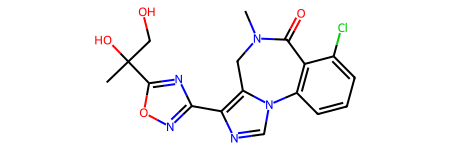

In [4]:
print(f"Name:\t{df.name[10]}\nSMILES:\t{df.smiles[10]}\nBBBP:\t{df.p_np[10]}")
molecule = molecule_from_smiles(df.iloc[10].smiles)
print("Molecule:")
molecule

In [5]:
import py3Dmol
from rdkit import Chem

# Przykładowy SMILES
smiles = "OCC(C)(O)c1onc(c2ncn3c2CN(C)C(c4c3cccc4Cl)=O)n1"  # Etanol
molecule = Chem.MolFromSmiles(smiles)

# Konwersja molekuły do formatu 3D
block = Chem.MolToMolBlock(molecule)

# Wizualizacja w 3D
view = py3Dmol.view(width=800, height=400)
view.addModel(block, 'mol')
view.setStyle({'stick': {}})
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
# graph = graph_from_molecule(molecule)
# print("Graph (including self-loops):")
# print("\tatom features\t", graph[0].shape)
# print("\tbond features\t", graph[1].shape)
# print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (27, 29)
	bond features	 (87, 7)
	pair indices	 (87, 2)


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph.
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = [features.size(0) for features in atom_features]
    num_bonds = [features.size(0) for features in bond_features]

    # Obtain partition indices (molecule_indicator)
    molecule_indices = torch.arange(len(num_atoms))
    molecule_indicator = molecule_indices.repeat_interleave(num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph
    gather_indices = torch.repeat_interleave(molecule_indices[:-1], num_bonds[1:])
    increment = torch.cumsum(torch.tensor(num_atoms[:-1]), dim=0)
    
    # Pad increment to match the size of the bonds
    increment = torch.cat((torch.zeros(num_bonds[0]), increment[gather_indices]))
    
    # Flatten and adjust pair_indices
    pair_indices = torch.cat([p + increment.unsqueeze(1) for p in pair_indices])
    
    # Flatten atom_features and bond_features
    atom_features = torch.cat(atom_features)
    bond_features = torch.cat(bond_features)

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch

class MPNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        x_item = self.X[index]
        y_item = self.y[index]
        return prepare_batch(x_item, y_item)

def create_dataloader(X, y, batch_size=32, shuffle=False):
    dataset = MPNNDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [14]:
import torch
import torch.nn as nn

class EdgeNetwork(nn.Module):
    def __init__(self):
        super(EdgeNetwork, self).__init__()

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = nn.Parameter(torch.Tensor(self.bond_dim, self.atom_dim * self.atom_dim))
        self.bias = nn.Parameter(torch.zeros(self.atom_dim * self.atom_dim))
        nn.init.xavier_uniform_(self.kernel)  # Inicjalizacja zgodna z glorot_uniform

    def forward(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = torch.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = bond_features.view(-1, self.atom_dim, self.atom_dim)

        # Obtain atom features of neighbors
        atom_features_neighbors = atom_features[pair_indices[:, 1]]
        atom_features_neighbors = atom_features_neighbors.unsqueeze(-1)

        # Apply neighborhood aggregation
        transformed_features = torch.matmul(bond_features, atom_features_neighbors)
        transformed_features = transformed_features.squeeze(-1)

        # Aggregate features using scatter_add
        aggregated_features = torch.zeros(atom_features.size(0), self.atom_dim).to(atom_features.device)
        aggregated_features.index_add_(0, pair_indices[:, 0], transformed_features)

        return aggregated_features


class MessagePassing(nn.Module):
    def __init__(self, units, steps=4):
        super(MessagePassing, self).__init__()
        self.units = units
        self.steps = steps
        self.message_step = EdgeNetwork()
        self.update_step = nn.GRUCell(self.units, self.units)

    def forward(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        pad_length = max(0, self.units - atom_features.size(1))
        
        if pad_length > 0:
            padding = torch.zeros(atom_features.size(0), pad_length).to(atom_features.device)
            atom_features_updated = torch.cat([atom_features, padding], dim=1)
        else:
            atom_features_updated = atom_features

        # Perform a number of steps of message passing
        for _ in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                (atom_features_updated, bond_features, pair_indices)
            )

            # Update node state via a step of GRU
            atom_features_updated = self.update_step(
                atom_features_aggregated,
                atom_features_updated
            )
        
        return atom_features_updated


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PartitionPadding(nn.Module):
    def __init__(self, batch_size):
        super(PartitionPadding, self).__init__()
        self.batch_size = batch_size

    def forward(self, inputs):
        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = [atom_features[molecule_indicator == i] for i in range(self.batch_size)]

        # Pad and stack subgraphs
        num_atoms = [f.size(0) for f in atom_features_partitioned]
        max_num_atoms = max(num_atoms)

        atom_features_stacked = []
        for f, n in zip(atom_features_partitioned, num_atoms):
            padded = F.pad(f, (0, 0, 0, max_num_atoms - n))  # Pad to max_num_atoms
            atom_features_stacked.append(padded)

        atom_features_stacked = torch.stack(atom_features_stacked)

        # Remove empty subgraphs (usually for last batch in dataset)
        non_empty_indices = (atom_features_stacked.sum(dim=(1, 2)) != 0).nonzero(as_tuple=True)[0]
        return atom_features_stacked[non_empty_indices]

class TransformerEncoderReadout(nn.Module):
    def __init__(self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32):
        super(TransformerEncoderReadout, self).__init__()

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.dense_proj = nn.Sequential(
            nn.Linear(embed_dim, dense_dim),
            nn.ReLU(),
            nn.Linear(dense_dim, embed_dim),
        )
        self.layernorm_1 = nn.LayerNorm(embed_dim)
        self.layernorm_2 = nn.LayerNorm(embed_dim)

    def forward(self, inputs):
        x = self.partition_padding(inputs)

        # Create padding mask
        padding_mask = (x != 0).any(dim=-1)
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, seq_len)

        attention_output, _ = self.attention(x, x, x, key_padding_mask=~padding_mask.squeeze(-1))
        
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))

        return proj_output.mean(dim=1)  # Global average pooling

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MPNNModel(nn.Module):
    def __init__(self, atom_dim, bond_dim, message_units=64, message_steps=4, num_attention_heads=8, dense_units=512):
        super(MPNNModel, self).__init__()
        
        self.message_passing = MessagePassing(message_units, message_steps)
        self.transformer_readout = TransformerEncoderReadout(num_heads=num_attention_heads, embed_dim=message_units, dense_dim=dense_units)
        
        self.dense1 = nn.Linear(dense_units, dense_units)
        self.dense2 = nn.Linear(dense_units, 1)

    def forward(self, atom_features, bond_features, pair_indices, molecule_indicator):
        x = self.message_passing((atom_features, bond_features, pair_indices))
        x = self.transformer_readout((x, molecule_indicator))
        
        x = F.relu(self.dense1(x))
        x = torch.sigmoid(self.dense2(x))
        
        return x


In [13]:
from rdkit import Chem

def molecule_from_smiles(smiles):
    """Funkcja pomocnicza do konwersji SMILES na cząsteczkę RDKit."""
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    Chem.SanitizeMol(molecule)  # Opcjonalnie: sanitizacja cząsteczki
    return molecule

In [18]:
# def graphs_from_smiles(smiles_list):
#     atom_features_list = []
#     bond_features_list = []
#     pair_indices_list = []

#     for smiles in smiles_list:
#         try:
#             molecule = molecule_from_smiles(smiles)
#             atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

#             atom_features_list.append(atom_features)
#             bond_features_list.append(bond_features)
#             pair_indices_list.append(pair_indices)
#         except ValueError as e:
#             print(e)  # Wyświetl błąd dla niepoprawnych SMILES

#     return (
#         [torch.tensor(features, dtype=torch.float32) for features in atom_features_list],
#         [torch.tensor(features, dtype=torch.float32) for features in bond_features_list],
#         [torch.tensor(indices, dtype=torch.int64) for indices in pair_indices_list],
#     )


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definiowanie modelu MPNN
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape,  # Upewnij się, że używasz drugiego wymiaru
    bond_dim=x_train[1][0][0].shape,  # Upewnij się, że używasz drugiego wymiaru
)

# Ustawienie optymalizatora i funkcji straty
optimizer = optim.Adam(mpnn.parameters(), lr=5e-4)

# Funkcja straty
def binary_crossentropy(predictions, targets):
    return nn.BCELoss()(predictions.view(-1), targets.view(-1))

# Przykładowa pętla treningowa
def train(model, data_loader):
    model.train()
    for atom_features, bond_features, pair_indices, molecule_indicator, targets in data_loader:
        optimizer.zero_grad()
        outputs = model(atom_features, bond_features, pair_indices, molecule_indicator)
        loss = binary_crossentropy(outputs, targets)
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item()}")

# Przykład użycia w pętli treningowej
# Zakładając `data_loader` jest instancją DataLoader z odpowiednimi danymi.


In [20]:
from torch.utils.data import Dataset

class MPNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [21]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Zakładam, że df jest już wczytany jako DataFrame
# df = pd.read_csv('path_to_your_data.csv')  # Przykład wczytania danych

class MPNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Funkcja do przekształcania SMILES na grafy
def graphs_from_smiles(smiles_list):
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        if molecule is None:
            continue  # Skip invalid SMILES
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)
        
        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    return (
        [torch.tensor(features, dtype=torch.float32) for features in atom_features_list],
        [torch.tensor(features, dtype=torch.float32) for features in bond_features_list],
        [torch.tensor(indices, dtype=torch.int64) for indices in pair_indices_list],
    )

# Shuffle array of indices ranging from 0 to the number of samples in df
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = torch.tensor(df.iloc[train_index].p_np.values, dtype=torch.float32)

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8): int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = torch.tensor(df.iloc[valid_index].p_np.values, dtype=torch.float32)

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99):]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = torch.tensor(df.iloc[test_index].p_np.values, dtype=torch.float32)

# Tworzenie datasetów
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

# Tworzenie dataloaderów
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Definiowanie modelu MPNN
mpnn_model = MPNNModel(
    atom_dim=x_train[0][0][0].shape,  # Upewnij się, że używasz drugiego wymiaru
    bond_dim=x_train[1][0][0].shape,  # Upewnij się, że używasz drugiego wymiaru
)

# Ustawienie optymalizatora
optimizer = optim.Adam(mpnn_model.parameters(), lr=5e-4)

# Funkcja straty
def binary_crossentropy(predictions, targets):
    return nn.BCELoss()(predictions.view(-1), targets.view(-1))

# Pętla treningowa
num_epochs = 40
train_auc_history = []
valid_auc_history = []

for epoch in range(num_epochs):
    mpnn_model.train()  # Ustaw model w trybie treningowym
    total_loss = 0.0
    all_targets = []
    all_predictions = []

    # Trening
    for atom_features, bond_features, pair_indices, molecule_indicator, targets in train_loader:
        optimizer.zero_grad()  # Zerowanie gradientów
        outputs = mpnn_model(atom_features, bond_features, pair_indices, molecule_indicator)
        
        loss = binary_crossentropy(outputs.squeeze(), targets)  # Squeeze to match dimensions if necessary
        loss.backward()  # Obliczanie gradientów
        optimizer.step()  # Aktualizacja wag
        
        total_loss += loss.item()
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(outputs.detach().cpu().numpy())

    # Obliczanie AUC dla zbioru treningowego
    train_auc = roc_auc_score(all_targets, all_predictions)
    train_auc_history.append(train_auc)

    # Walidacja
    mpnn_model.eval()  # Ustaw model w trybie ewaluacji
    valid_targets = []
    valid_predictions = []

    with torch.no_grad():  # Wyłącz obliczanie gradientów dla walidacji
        for atom_features, bond_features, pair_indices, molecule_indicator, targets in valid_loader:
            outputs = mpnn_model(atom_features, bond_features, pair_indices, molecule_indicator)
            valid_targets.extend(targets.cpu().numpy())
            valid_predictions.extend(outputs.detach().cpu().numpy())

    # Obliczanie AUC dla zbioru walidacyjnego
    valid_auc = roc_auc_score(valid_targets, valid_predictions)
    valid_auc_history.append(valid_auc)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}")

# Wizualizacja wyników AUC
plt.figure(figsize=(10, 6))
plt.plot(train_auc_history, label="Train AUC")
plt.plot(valid_auc_history, label="Valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)
plt.title("Training and Validation AUC over Epochs", fontsize=18)
plt.show()


IndexError: tuple index out of range

In [28]:
train_dataset[0]

([tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 

In [23]:
train_loader[0]

TypeError: 'DataLoader' object is not subscriptable